# BuenoJob - умный поиск вакансий на рынке айти

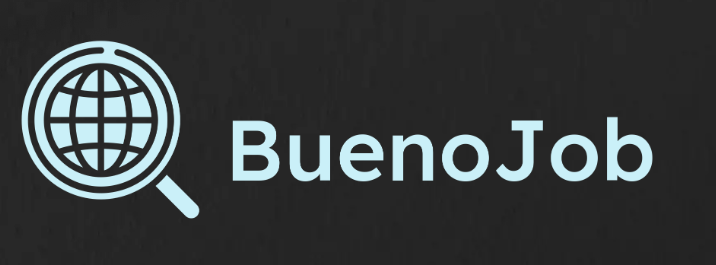

Суть проекта - поиск по вакансиям различных сайтов вакансий специализированных в секторе айти.

Технологии: Hugging Face (SBERT), Streamlit, Qdrant, Pandas

Алгоритм полностью работает на CPU, для получения инференсов не требуется поддержка GPU.

Что готово на данный момент (альфа-версия):

* вшита предобученная модель Sentence-BERT
* реализация парсинга вакансий с hh.ru через API
* сохранение описания вакансий в векторном виде вместе с мета-данными в Qdrant (потребуется иметь кластер - один кластер предоставляется бесплатно)
* можно парсить от 1 до 1000 вакансий из любого числа городов (чтобы не перегружать API)
* вся работа реализована на CPU, использование GPU не требуется
* готова визуализация на Streamlit.

In [1]:
!pip install qdrant-client -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 78.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 15.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 5.29.3 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.

In [2]:
from typing import Optional, List, Dict
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from sentence_transformers import SentenceTransformer
import requests
import re
import pandas as pd


BASE_URL = "https://api.hh.ru/vacancies"
resume_file_path = '/kaggle/input/my-resume/myresume.txt'

In [3]:
hh_areas = {
    1: "Москва",
    2: "Санкт-Петербург",
    3: "Новосибирск",
    4: "Екатеринбург",
    5: "Нижний Новгород",
    6: "Казань",
    7: "Челябинск",
    8: "Самара",
    9: "Омск",
    10: "Ростов-на-Дону",
    11: "Уфа",
    12: "Красноярск",
    13: "Воронеж",
    14: "Пермь",
    15: "Волгоград",
    16: "Краснодар",
    17: "Саратов",
    18: "Тюмень",
    19: "Тольятти",
    113: "Россия (все регионы)"
}

# SBERT and Cosine Similarity

Использование предобученной модели Sentence BERT и косинусной близости для перевода текста в вектор и последующего попарного сравнения вектора резюме и векторов вакансий.

**Внимание!** Для работы в ноутбуке (и в Streamlit-приложении) обязательно наличие кластера в базе данных Qdrant (любой пользователь может получить один кластер бесплатно - его хватит за глаза).

In [4]:
qdrant_client = QdrantClient(
    url="https://123123123aaa.gcp.cloud.qdrant.io",
    api_key="aaaaaa-BBBBBBBB-ccccccccc"
)
print("Successfully connected to Qdrant!")

Successfully connected to Qdrant!


In [5]:
collection_name = 'ClusterName'

qdrant_client.recreate_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=768, distance=Distance.COSINE)
)

<ipython-input-5-986a612aeb63>:3: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


True

In [6]:
def load_resume_from_file(filepath: str) -> str:
    """
    Загрузка текста резюме из файла.

    :param filepath: Путь к файлу с резюме.
    :return: Содержимое файла в виде строки.
    """
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read().replace('\n\n', ' ').replace('\n', ' ')

In [7]:
model = SentenceTransformer('DeepPavlov/rubert-base-cased-sentence')
resume_text = load_resume_from_file(resume_file_path)
resume_vector = model.encode(resume_text).tolist()

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Определим все основные функции, с которыми мы будем работать.

In [8]:
def get_total_vacancies(
    text: str = "аналитик данных",
    experience: str = "noExperience",
    area: int = 113
) -> int:
    """
    Возвращает общее количество вакансий по запросу.

    :param text: Ключевые слова для поиска вакансий.
    :param experience: Уровень опыта работы.
    :param area: ID города или региона.
    :return: Общее количество вакансий.
    """
    url = "https://api.hh.ru/vacancies"
    params = {
        "text": text,
        "experience": experience,
        "area": area,
        "per_page": 1  # Запрашиваем только одну вакансию, чтобы узнать общее количество
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        return data.get("found", 0)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching total vacancies: {e}")
        return 0

In [9]:
def determine_pages_per_view(total_vacancies: int) -> int:
    """
    Автоматически определяет оптимальное значение per_page.

    :param total_vacancies: Общее количество вакансий.
    :return: Значение per_page.
    """
    if total_vacancies >= 100:
        return 100
    elif total_vacancies >= 50:
        return 50
    elif total_vacancies >= 10:
        return 10
    else:
        return 1

In [10]:
def get_vacancies(
    text: str = "аналитик данных",
    experience: str = "noExperience",
    area: int = 113,
    page: int = 0,
    per_page: int = 10
) -> Optional[Dict]:
    """
    Получает список вакансий с hh.ru.

    :param text: Ключевые слова для поиска вакансий.
    :param experience: Уровень опыта работы (например, "noExperience").
    :param area: Регион поиска вакансий.
    :param page: Номер страницы для пагинации.
    :param per_page: Количество вакансий на странице.
    :return: JSON-объект с вакансиями или None в случае ошибки.
    """
    params = {
        "text": text,
        "experience": experience,
        "area": area,
        "page": page,
        "per_page": per_page
    }

    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        vacancies = response.json()

        for item in vacancies['items']:
            vacancy_response = requests.get(f"https://api.hh.ru/vacancies/{item['id']}")
            vacancy_response.raise_for_status()
            item['full_description'] = re.sub(r'<\w+>|<\/\w+>|&quot', '', vacancy_response.json()['description'])
        return vacancies
    except requests.exceptions.RequestException as e:
        print(f"Error during API request: {e}")
        return None
    except:
        print('Произошла ошибка')
        return None

In [11]:
def save_to_qdrant(
    vacancies_vectors: List[List[float]],
    vacancies: Dict,
    client: QdrantClient,
    collection_name: str
) -> None:
    """
    Сохраняет векторы вакансий и их метаданные в коллекцию Qdrant.

    :param vacancies_vectors: Список векторных представлений вакансий.
    :param vacancies: JSON-объект с вакансиями.
    :param client: Клиент Qdrant.
    :param collection_name: Название коллекции в Qdrant.
    """
    points = []
    for vector, vacancy in zip(vacancies_vectors, vacancies['items']):
        if vector is not None:
            points.append({
                "id": int(vacancy['id']),
                "vector": vector.tolist(),
                "payload": {
                    "name": vacancy['name'],
                    "url": vacancy['alternate_url'],
                    "employer": vacancy['employer']['name'],
                    "area": vacancy["area"]["name"]
                }
            })
    client.upsert(collection_name=collection_name, points=points)


def search_qdrant(
    client: QdrantClient,
    collection_name: str,
    query_vector: List[float],
    top_k: int = 10
) -> List[Dict[str, str]]:
    """
    Выполняет поиск похожих вакансий в коллекции Qdrant.

    :param client: Клиент Qdrant.
    :param collection_name: Название коллекции в Qdrant.
    :param query_vector: Вектор запроса.
    :param top_k: Количество результатов поиска.
    :return: Список словарей с данными о вакансиях.
    """
    search_result = client.query_points(
        collection_name=collection_name,
        query=query_vector,
        limit=top_k,
        with_payload=True
    )
    return [
        {
            "vacancy": hit.payload["name"],
            "similarity": hit.score,
            "url": hit.payload["url"],
            "employer": hit.payload["employer"],
            "area": hit.payload["area"]
        }
        for hit in search_result.points
    ]

In [12]:
def find_vacations(
    text: str = 'Аналитик данных',
    experience: str = "noExperience",
    areas: List[int] = [113],
    total_vacancies = None
) -> None:
    """
    Загружает вакансии с hh.ru, векторизует их и сохраняет в Qdrant.

    :param per_page: Количество вакансий на странице.
    :param text: Ключевые слова для поиска вакансий.
    :param total_pages: Количество страниц для загрузки вакансий.
    :param experience: Уровень опыта работы.
    :param area: Регион поиска вакансий.
    :param total_vacancies: Сколько всего вакансий загружать (вместе взятых со всех городов)
    """
    total_vacancies_loaded = 0
    total_vacancies_per_area = total_vacancies
    
    for area in areas:
        if total_vacancies_loaded >= 1000:
            break
        print(f"Processing area {hh_areas[area]}...")

        total_vacancies = total_vacancies_per_area
        
        if total_vacancies is None:
            total_vacancies = get_total_vacancies(text, experience, area) # если число вакансий 0, смотрим, сколько всего у нас может быть
        else:
            total_vacancies_check = get_total_vacancies(text, experience, area) # если указан не 0, проверяем, сколько вообще вакансий есть
            if total_vacancies_check < total_vacancies and total_vacancies_check > 0:
                print(f"Found only {total_vacancies_check} vacancies in area {hh_areas[area]}...")
                total_vacancies = total_vacancies_check # если число найденных вакансий меньше введённых, то парсим число найденных
            elif total_vacancies_check == 0:
                print(f"No vacancies in area {hh_areas[area]}...")
                break
            
        per_page = determine_pages_per_view(total_vacancies)
        total_pages = (total_vacancies + per_page - 1) // per_page

        print('per_page:', per_page, 'total_pages:', total_pages, 'total_vacancies:', total_vacancies)

        for page in range(total_pages):
            print(f"Fetching page {page + 1} for area {hh_areas[area]}...")
            if page == total_pages - 1:
                per_page = total_vacancies % per_page or per_page
                print('per_page:', per_page)
                
            vacancies = get_vacancies(text=text, per_page=per_page, page=page, experience=experience, area=area)
            if not vacancies:
                print(f"No vacancies found for area {hh_areas[area]}, page {page + 1}.")
                break

            print(f"Vectorizing vacancies for area {hh_areas[area]}, page {page + 1}...")
            descriptions = [item['full_description'] for item in vacancies['items'] if item['full_description']]
            vacancies_vectors = model.encode(descriptions)

            print(f"Saving vacancies for area {hh_areas[area]}, page {page + 1} to Qdrant...")
            save_to_qdrant(vacancies_vectors, vacancies, qdrant_client, collection_name)

            total_vacancies_loaded += per_page

            if total_vacancies_loaded >= 1000:
                break

            print('total_vacancies_loaded:', total_vacancies_loaded)

        print(f"Finished processing area {hh_areas[area]}.\n")

Запускаем обработку резюме и описания вакансий, которые уже подгружены в векторную базу Qdrant.

In [13]:
text = 'Аналитик данных'
experience = "noExperience"
areas = [2, 1]

find_vacations(text=text, experience=experience, areas=areas, total_vacancies=10)

Processing area Санкт-Петербург...
per_page: 10 total_pages: 1 total_vacancies: 10
Fetching page 1 for area Санкт-Петербург...
per_page: 10
Vectorizing vacancies for area Санкт-Петербург, page 1...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Saving vacancies for area Санкт-Петербург, page 1 to Qdrant...
total_vacancies_loaded: 10
Finished processing area Санкт-Петербург.

Processing area Москва...
per_page: 10 total_pages: 1 total_vacancies: 10
Fetching page 1 for area Москва...
per_page: 10
Vectorizing vacancies for area Москва, page 1...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Saving vacancies for area Москва, page 1 to Qdrant...
total_vacancies_loaded: 20
Finished processing area Москва.



In [14]:
similarities = search_qdrant(qdrant_client, collection_name, resume_vector, top_k=25)
similarities_df = pd.DataFrame(similarities).sort_values(by='similarity', ascending=False)

In [15]:
# Вывод результатов
display(similarities_df)

,vacancy,similarity,url,employer,area
0,Младший системный аналитик,0.898514,https://hh.ru/vacancy/115371279,МетаПрайм,Санкт-Петербург
1,Начинающий системный аналитик,0.889692,https://hh.ru/vacancy/115823869,Долгих Георгий,Москва
2,"Стажер, Data Analyst / Data Scientist",0.888149,https://hh.ru/vacancy/116034730,Kept (Кэпт),Москва
3,Специалист группы коммерческой аналитики,0.882368,https://hh.ru/vacancy/116019031,Аэрофлот,Москва
4,Стажер в команду системного анализа,0.875527,https://hh.ru/vacancy/115899422,Честный знак.рф,Санкт-Петербург
5,Системный аналитик,0.864813,https://hh.ru/vacancy/116080503,Coco IT,Москва
6,Младший Аналитик (Junior Analyst),0.854227,https://hh.ru/vacancy/115923013,DiagnoCat,Москва
7,Ассистент аналитика,0.849774,https://hh.ru/vacancy/116172463,FIX PRICE,Москва
8,Специалист по подбору персонала,0.847727,https://hh.ru/vacancy/114952414,буше,Санкт-Петербург
9,Junior IT специалист | Системный аналитик,0.847093,https://hh.ru/vacancy/115987041,Soar high software,Санкт-Петербург


# Удаление всех результатов в векторной базе

Для служебного пользования - очищение векторной базы.

In [16]:
from qdrant_client.http.models import PointIdsList


scroll_result = qdrant_client.scroll(
    collection_name=collection_name,
    limit=147,
    with_vectors=False,
    with_payload=True,
)

ids_to_delete = []

for point in scroll_result[0]:
    ids_to_delete.append(point.id)

qdrant_client.delete(
    collection_name=collection_name,
    points_selector=PointIdsList(
        points=ids_to_delete,
    ),
)

UpdateResult(operation_id=2, status=<UpdateStatus.COMPLETED: 'completed'>)

# Заключение

Веб-приложение находится в ранней стадии развития. В дальнейшем что планируется:

* Использование LLM для улучшения семантического поиска.
* Подключение других API (LinkedIn, habr.карьера и др.).
* Оптимизация.